In [28]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score, matthews_corrcoef, confusion_matrix, make_scorer)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC

In [29]:
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import re
import random
from scipy import stats
from scipy.stats import t
from itertools import chain

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import binary_cross_entropy

In [ ]:
#!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler

In [32]:
#!pip install psyke==0.8.9

In [33]:
from psyke import Extractor, Clustering, EvaluableModel
from psyke.extraction.hypercubic.strategy import AdaptiveStrategy
from psyke.extraction.hypercubic import Grid, FeatureRanker
from psyke.tuning.orchid import OrCHiD
from psyke.tuning.crash import CRASH
from psyke.utils.logic import pretty_theory
from psyke.utils import Target
from psyke.schema import LessThan, GreaterThan, Between

In [34]:
# function to parse rules from theories
def parse_rules(rule_string):
    opposite_signs = {
        '<': '>',
        '>': '<',
        '<=': '>=',
        '>=': '<=',
        '=<': '=>',
        '=>': '=<',
    }
    rules = []
    # predicate with rules
    rule_pattern = re.compile(r"'Outcome'\((.*?)\)\s:-\s*(.*?)\.($|\s)")
    # final predicate with no rules
    rule_pattern_end = re.compile(r"'Outcome'\((.*?)\)\.")
    # rule condition
    condition_pattern = re.compile(r'([a-zA-Z]+)\s*([=<>]+)\s*([0-9.-]+)')
    # rule interval
    interval_pattern = re.compile(r"([a-zA-Z]+)\s+in\s+\[([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+)\]")
    for match in rule_pattern.finditer(rule_string):
        outcome = match.group(1).strip().split()[-1]
        conditions_str = match.group(2).strip()
        conditions = []
        # condition with less than / greater than
        for condition_match in condition_pattern.finditer(conditions_str):
            variable = condition_match.group(1)
            operation = condition_match.group(2)
            threshold = float(condition_match.group(3))
            conditions.append({
                "variable": variable,
                "operation": operation,
                "threshold": threshold
            })
        # condition with interval
        for condition_match in interval_pattern.finditer(conditions_str):
            variable = condition_match.group(1)
            lower_bound = float(condition_match.group(2))
            upper_bound = float(condition_match.group(3))
            conditions.extend([
                {"variable": variable,
                "operation": ">=",
                "threshold": lower_bound},
                {"variable": variable,
                "operation": "<=",
                "threshold": upper_bound}           
            ]) 
        rules.append({
            "conditions": conditions,
            "outcome": outcome
        })
    # rule with no conditions
    for match in rule_pattern_end.finditer(rule_string):
        outcome = match.group(1).strip().split()[-1]
        rules.append({
            "conditions": [],
            "outcome": outcome
        })
    return rules

In [35]:
# define rules from the knowledge base
def get_kb_rules():
    return [ {"conditions" : [{"variable" : "BMI",
                                      "operation" : "<=",
                                      "threshold" : 25},
                                     {"variable" : "Glucose",
                                      "operation" : "<=",
                                      "threshold" : 100}],
                     "outcome" : "healthy"},
                    {"conditions" : [{"variable" : "BMI",
                                      "operation" : ">=",
                                      "threshold" : 30},
                                     {"variable" : "Glucose",
                                      "operation" : ">=",
                                      "threshold" : 126}],
                     "outcome" : "diabetes"}]

In [36]:
def get_outcome(sample, rules): 
    outcome = np.nan
    for rule in rules:
        conditions_met = all(apply_condition(cond["operation"], sample[cond["variable"]],cond["threshold"]) for cond in rule['conditions'])
        if conditions_met:
            outcome = rule["outcome"]
            break
    return outcome

In [ ]:
def get_rule(rules, sample): 
    outcome = np.nan
    for id, rule in enumerate(rules):
        conditions_met = all(apply_condition(cond["operation"], sample[cond["variable"]],cond["threshold"]) for cond in rule['conditions'])
        if conditions_met:
            outcome = rule["outcome"]
            break
    return id, outcome

In [37]:
def apply_condition(operation, value, threshold):
    if operation == "<=":
        return value <= threshold
    if operation == "=<":
        return value <= threshold
    elif operation == "<":
        return value < threshold
    if operation == ">=":
        return value >= threshold
    if operation == "=>":
        return value >= threshold
    elif operation == ">":
        return value > threshold

In [38]:
# functions to print scores for the generated rules
def print_scores(scores):
    print(f'Classification accuracy = {scores[EvaluableModel.ClassificationScore.ACCURACY][0]:.2f} (data), '
          f'{scores[EvaluableModel.ClassificationScore.ACCURACY][1]:.2f} (BB)\n'
          f'F1 = {scores[EvaluableModel.ClassificationScore.F1][0]:.2f} (data), '
          f'{scores[EvaluableModel.ClassificationScore.F1][1]:.2f} (BB)')

def get_scores(extractor, test, predictor):
    return extractor.score(test, predictor, True, True, False, task=EvaluableModel.Task.CLASSIFICATION,
                           scoring_function=[EvaluableModel.ClassificationScore.ACCURACY,
                                             EvaluableModel.ClassificationScore.F1])

In [39]:
# function to compute performance metrics
def get_results(y_pred, y_test):
    a   = accuracy_score(y_test, y_pred)
    ba  = balanced_accuracy_score(y_test, y_pred)
    p   = precision_score(y_test, y_pred)
    r   = recall_score(y_test, y_pred)
    sp  = recall_score(y_test, y_pred, pos_label=0)
    f1  = f1_score(y_test, y_pred, average="macro")
    roc = roc_auc_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return [a, ba, p, r, sp, f1, roc, mcc]

In [40]:
# function to compute accuracy with respect to a rule-based system
def get_relative_accuracy(y_test, y_rule, y_pred):
    return sum((y_test == y_rule) & (y_rule == y_pred.round())) / sum(y_test == y_rule)
 
def get_relative_sensitivity(y_test, y_rule, y_pred):
    return sum((y_test == y_rule) & (y_test == 1) & (y_rule == y_pred.round())) / sum((y_test == y_rule) & (y_test == 1))
 
def get_relative_specificity(y_test, y_rule, y_pred):
    return sum((y_test == y_rule) & (y_test == 0) & (y_rule == y_pred.round())) / sum((y_test == y_rule) & (y_test == 0))

In [41]:
# function to generate a summary table
def get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test):
    res = pd.DataFrame(index = scores_ml.columns, columns = ["ML_mean","ML_std","KB-ML_mean","KB-ML_std"])
    res["ML_mean"] = scores_ml.mean().round(3)
    res["ML_std"] = scores_ml.std().round(3)
    res["KB-ML_mean"] = scores_kbml.mean().round(3)
    res["KB-ML_std"] = scores_kbml.std().round(3)
    res["p-value"] = np.nan
    res["corr_p-value"] = np.nan
    for c in res.index:
        difference = scores_ml[c].values - scores_kbml[c].values
        # uncorrected paired t-test p-value
        t_stat_uncorrected = np.mean(difference) / np.sqrt(np.var(difference, ddof=1) / (n_1+1))
        p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), n_1)
        res.loc[c,"p-value"] = p_val_uncorrected.round(4)
        # corrected paired t-test p-value
        t_stat, p_val = compute_corrected_ttest(difference, n_1, n_train, n_test)
        res.loc[c,"corr_p-value"] = p_val.round(4)
    return res

In [42]:
# function to correct the standard deviation using Nadeau and Bengio's approach.
def corrected_std(differences, n_train, n_test):
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

# function to compute right-tailed paired t-test with corrected variance.
def compute_corrected_ttest(differences, df, n_train, n_test):
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [43]:
def confusion_matrix_components(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total = tn + fp + fn + tp
    tn_rate = tn / total
    fp_rate = fp / total
    fn_rate = fn / total
    tp_rate = tp / total
    return {'tn_rate': tn_rate, 'fp_rate': fp_rate, 'fn_rate': fn_rate, 'tp_rate': tp_rate}

## Results 1 - ML performance

In [44]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [45]:
# import dataset
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [46]:
# define the hyperparameter grid for each model
param_grids = {
    'DecisionTree': {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [5, 10]
    },
    'GradientBoosting': {
        'n_estimators': np.linspace(50, 250, 5).astype(int),
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'MultiLayerPerceptron': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (30, 30, 30), (50, 30, 20), (100, 50, 25)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'adaptive']
    },
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'RandomForest': {
        'n_estimators': np.linspace(50, 250, 5).astype(int),
        #'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [5, 10]
    },
    'KNearestNeighbor': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

In [47]:
# define the models
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=123),
    'GradientBoosting': GradientBoostingClassifier(random_state=123),
    'MultiLayerPerceptron': MLPClassifier(random_state=123, max_iter=2000),
    'LogisticRegression': LogisticRegression(random_state=123, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=123),
    'KNearestNeighbor': KNeighborsClassifier()
}

In [48]:
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'mcc': make_scorer(matthews_corrcoef)
}

In [49]:
# perform nested cross-validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
# initialize a dictionary to store results
results = {model: {**{metric: [] for metric in scorers}, 'tn_rate': [], 'fp_rate': [], 'fn_rate': [], 'tp_rate': []} for model in models}

all_pred = {model: [] for model in models}
# perform nested cross-validation
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
   
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        clf = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring=scorers, refit='recall', 
                                           cv=inner_cv, n_jobs=-1).fit(X_train, y_train)       
        y_pred = clf.predict(X_test)
        results[model_name]['accuracy'].append(accuracy_score(y_test, y_pred))
        results[model_name]['precision'].append(precision_score(y_test, y_pred))
        results[model_name]['recall'].append(recall_score(y_test, y_pred))
        results[model_name]['f1'].append(f1_score(y_test, y_pred))
        results[model_name]['balanced_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
        results[model_name]['mcc'].append(matthews_corrcoef(y_test, y_pred))
        cm = confusion_matrix_components(y_test, y_pred)
        results[model_name]['tn_rate'].append(cm['tn_rate'])
        results[model_name]['fp_rate'].append(cm['fp_rate'])
        results[model_name]['fn_rate'].append(cm['fn_rate'])
        results[model_name]['tp_rate'].append(cm['tp_rate'])
        all_pred[model_name].extend(list(y_pred))

Evaluating DecisionTree...
Evaluating GradientBoosting...
Evaluating MultiLayerPerceptron...
Evaluating LogisticRegression...
Evaluating RandomForest...
Evaluating KNearestNeighbor...


In [930]:
# flatten the dictionary structure
data = []
for model, metrics in results.items():
    for metric, values in metrics.items():
        for i, value in enumerate(values):
            data.append((model, metric, i, value))
# save performance scores
df = pd.DataFrame(data, columns=['model', 'metric', 'fold','value'])
df.to_csv("woa_cv_results.csv")

In [55]:
# save predictions
test_indices = np.concatenate([test_idx for _, test_idx in outer_cv.split(X, y)])
res_df = pd.DataFrame(all_pred, index = test_indices).sort_index()
res_df.to_csv("woa_cv_predictions.csv")

In [57]:
# import dataset and results
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
df = pd.read_csv("woa_cv_results.csv", index_col = 0)
res_df = pd.read_csv("woa_cv_predictions.csv", index_col = 0)

In [61]:
# compute predicted outcome based on rule
dataset_rules = dataset.copy()
dataset_rules["Rules"] = np.nan
dataset_rules.loc[(dataset_rules["BMI"] >= 30) & (dataset_rules["Glucose"] >= 126), "Rules"] = 1
dataset_rules.loc[(dataset_rules["BMI"] <= 25) & (dataset_rules["Glucose"] <= 100), "Rules"] = 0

In [62]:
means_df = df.groupby(["model","metric"])["value"].mean().unstack(level=1).round(3).sort_values(
    by = "recall", ascending = False)
means_df 

metric,accuracy,balanced_accuracy,f1,fn_rate,fp_rate,mcc,precision,recall,tn_rate,tp_rate
model,,,,,,,,,,
GradientBoosting,0.750,0.724,0.639,0.126,0.124,0.450,0.645,0.638,0.527,0.223
DecisionTree,0.741,0.713,0.624,0.132,0.128,0.432,0.636,0.623,0.523,0.217
KNearestNeighbor,0.743,0.708,0.614,0.143,0.113,0.429,0.653,0.589,0.538,0.206
RandomForest,0.759,0.718,0.626,0.146,0.095,0.456,0.686,0.582,0.556,0.203
LogisticRegression,0.762,0.715,0.619,0.154,0.085,0.464,0.714,0.560,0.566,0.195
MultiLayerPerceptron,0.706,0.655,0.530,0.178,0.116,0.333,0.608,0.488,0.535,0.170


In [64]:
models_order = list(means_df.index)
res_df["pred_mean"] = res_df[models_order].mean(axis = 1)
res_df["Outcome"] = dataset["Outcome"]
res_df["ClinicalProtocol"] = dataset_rules["Rules"]
res_df["EQ"] = res_df["Outcome"]==res_df["ClinicalProtocol"]
res_df = res_df.fillna(-1)
res_df = res_df[['Outcome', 'ClinicalProtocol', 'EQ', 'pred_mean'] + models_order]
res_df = res_df.sort_values(['Outcome','ClinicalProtocol','EQ','pred_mean'], ascending=[False]*4)
res_df_index = res_df.index
res_df = res_df.reset_index(drop = True)

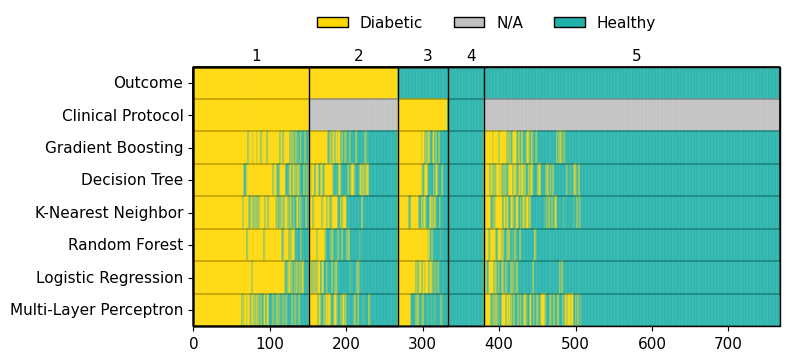

In [67]:
plt.rcParams['patch.edgecolor'] = 'none'

fig, axes = plt.subplots(figsize=(8, 3.8))

cmap = LinearSegmentedColormap.from_list('rg', [ "silver", "lightseagreen", "gold"], N=256) 
sns.heatmap(res_df.drop(columns = ["EQ","pred_mean"]).T, cmap=cmap, cbar=False, alpha=0.4, xticklabels = 100, linewidths=0.1, ax=axes)
axes.set_yticklabels(['Outcome', 'Clinical Protocol', 'Gradient Boosting', 'Decision Tree', 'K-Nearest Neighbor', 'Random Forest', 
                      'Logistic Regression', 'Multi-Layer Perceptron'])
axes.tick_params(axis='both', which='major', labelsize=11)
colors = axes.collections[0].get_facecolors()
axes.collections[0].set_edgecolors(colors)

for r in range(1,len(res_df.columns)-1):
    axes.add_patch(Rectangle((0, 0),  len(res_df), r, fill=False, edgecolor="black", lw=0.3, clip_on=False))
axes.add_patch(Rectangle((0, 0), len(res_df), 8, fill=False, edgecolor="black", lw=1, clip_on=False))

n1 = len(res_df[(res_df["Outcome"]==1) & (res_df["ClinicalProtocol"]==1)])
n2 = len(res_df[(res_df["Outcome"]==1)])
n3 = len(res_df[(res_df["Outcome"]==1)]) + len(res_df[(res_df["Outcome"]==0) & (res_df["ClinicalProtocol"]==1)])
n4 = len(res_df) - len(res_df[(res_df["Outcome"]==0) & (res_df["ClinicalProtocol"]==-1)])
n5 = len(res_df)

axes.add_patch(Rectangle((0, 0), n1, 8, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n2, 8, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n3, 8, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n4, 8, fill=False, edgecolor="black", lw=1, clip_on=False))

plt.text(n1/2,     -0.2, "1", size=11)
plt.text((n1+n2)/2,-0.2, "2", size=11)
plt.text((n2+n3)/2,-0.2, "3", size=11)
plt.text((n3+n4)/2,-0.2, "4", size=11)
plt.text((n4+n5)/2,-0.2, "5", size=11)

legend_elements = [
    Patch(facecolor="gold", edgecolor="black", label="Diabetic"),
    Patch(facecolor="silver", edgecolor="black", label="N/A"),
    Patch(facecolor="lightseagreen", edgecolor="black", label="Healthy")
]

legend = axes.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, fontsize=11)
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')
plt.subplots_adjust(hspace=0.2)
plt.tight_layout()
plt.show()
#plt.savefig("ml_models.pdf")

## Results 2 - KB integration

In [1969]:
def sampling(experiment, X_train, y_train):
    if experiment == "oversampling":
        return RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    elif experiment == "undersampling":
        return RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
    else:
        return X_train, y_train

In [1970]:
def train_and_evaluate(model_name, X_train, y_train, X_test, y_test):
    predictor = GridSearchCV(models[model_name], param_grids[model_name], n_jobs=-1, cv=3)
    predictor.fit(X_train, y_train)
    best_params = predictor.best_params_
    predictor = models[model_name].set_params(**best_params)
    predictor.fit(X_train, y_train)
    score = predictor.score(X_test, y_test)
    print(f"{model_name} A = {score:.2f}\n")
    return predictor

In [1971]:
def extract_and_process_rules(predictor, train, test, depth, res_df, col_ml, col_kbml, kb_rules):
    cart = Extractor.cart(predictor, max_depth=depth, max_leaves=depth, simplify=False)
    theory_from_cart = cart.extract(train)
    scores, completeness = get_scores(cart, test, predictor)
    print(f'CART performance ({cart.n_rules} rules with {completeness * 100:.2f}% coverage):')
    #print(pretty_theory(theory_from_cart))
    print_scores(scores)
    print()
    
    ml_rules = parse_rules(pretty_theory(theory_from_cart))
    for index, row in test.iterrows():
        outcome = get_outcome(row, ml_rules)
        res_df[col_ml].loc[index] = 0 if outcome == "healthy" else 1

    for index, row in test.iterrows():
        outcome = get_outcome(row, kb_rules)
        if isinstance(outcome, float) and np.isnan(outcome):
            outcome = get_outcome(row, ml_rules)
        res_df[col_kbml].loc[index] = 0 if outcome == "healthy" else 1
    return theory_from_cart

In [1972]:
def calculate_metrics(y_test, y_pred):
    res_dict = {}
    res_dict['accuracy'] = accuracy_score(y_test, y_pred)
    res_dict['precision'] = precision_score(y_test, y_pred)
    res_dict['recall'] = recall_score(y_test, y_pred)
    res_dict['f1'] = f1_score(y_test, y_pred)
    res_dict['balanced_accuracy'] = balanced_accuracy_score(y_test, y_pred)
    res_dict['mcc'] = matthews_corrcoef(y_test, y_pred)
    cm = confusion_matrix_components(y_test, y_pred)
    res_dict['tn_rate'] = cm['tn_rate']
    res_dict['fp_rate'] = cm['fp_rate']
    res_dict['fn_rate'] = cm['fn_rate']
    res_dict['tp_rate'] = cm['tp_rate']
    return res_dict

In [2124]:
# select sampling type
experiment = "none"
# rules extracted
depth = 20
# import knowledge
kb_rules = get_kb_rules()

In [2125]:
# initialise dataset
res_df = pd.DataFrame()
res_df["Outcome"] = dataset_rules["Outcome"]
res_df["ClinicalProtocol"] = dataset_rules["Rules"]
res_df["EQ"] = res_df["Outcome"]==res_df["ClinicalProtocol"]
res_df = res_df.fillna(-1)
res_df["GB_CART_ML"] = np.nan
res_df["GB_CART_KBML"] = np.nan
res_df["DT_ML"] = np.nan
res_df["DT_KBML"] = np.nan

In [2126]:
# import dataset
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
dataset["Outcome"].replace({0: 'healthy', 1: 'diabetes'}, inplace=True)

# split data
train, test = train_test_split(dataset, test_size=0.5, random_state=42, stratify=dataset["Outcome"])

X_train, y_train, X_test, y_test = train.iloc[:, :-1], train.iloc[:, -1], test.iloc[:, :-1], test.iloc[:, -1]
X_train, y_train = sampling(experiment, X_train, y_train)

predictor = train_and_evaluate('GradientBoosting', X_train, y_train, X_test, y_test)
_ = extract_and_process_rules(predictor, train, test, depth, res_df, "GB_CART_ML", "GB_CART_KBML", kb_rules)

predictor = train_and_evaluate('DecisionTree', X_train, y_train, X_test, y_test)
outcomes = predictor.predict(test.iloc[:, :-1])
res_df["DT_ML"].loc[test.index] = [0 if o == "healthy" else 1 for o in outcomes]

# flip and retrain
train, test = test, train
X_train, y_train, X_test, y_test = train.iloc[:, :-1], train.iloc[:, -1], test.iloc[:, :-1], test.iloc[:, -1]
X_train, y_train = sampling(experiment, X_train, y_train)

predictor = train_and_evaluate('GradientBoosting', X_train, y_train, X_test, y_test)
_ = extract_and_process_rules(predictor, train, test, depth, res_df, "GB_CART_ML", "GB_CART_KBML", kb_rules)

predictor = train_and_evaluate('DecisionTree', X_train, y_train, X_test, y_test)
outcomes = predictor.predict(test.iloc[:, :-1])
res_df["DT_ML"].loc[test.index] = [0 if o == "healthy" else 1 for o in outcomes]

res_df['DT_KBML'] = np.where(res_df['ClinicalProtocol'] != -1, res_df['ClinicalProtocol'], res_df['DT_ML'])

GradientBoosting A = 0.75

CART performance (20 rules with 100.00% coverage):
Classification accuracy = 0.72 (data), 0.89 (BB)
F1 = 0.71 (data), 0.89 (BB)

DecisionTree A = 0.70

GradientBoosting A = 0.76

CART performance (20 rules with 100.00% coverage):
Classification accuracy = 0.76 (data), 0.92 (BB)
F1 = 0.75 (data), 0.92 (BB)

DecisionTree A = 0.72



In [2127]:
# compute metrics
results = []
subres = res_df[res_df["ClinicalProtocol"]!=-1]
y_test = subres["Outcome"]
y_pred = subres["ClinicalProtocol"]
res_dict = calculate_metrics(y_test, y_pred)
res_dict['coverage'] = len(subres)/len(res_df)
results.append(res_dict)

y_test = res_df["Outcome"]
for pred_col in res_df.columns[-4:]:
    y_pred = res_df[pred_col]
    res_dict = calculate_metrics(y_test, y_pred)
    res_dict['coverage'] = 1.0
    results.append(res_dict)

pd.DataFrame(results, index = ['Clinical Protocol', 'GB-CART', 'GB-CART + KB', 'DT', 'DT + KB']).round(3)

,accuracy,precision,recall,f1,balanced_accuracy,mcc,tn_rate,fp_rate,fn_rate,tp_rate,coverage
Clinical Protocol,0.755,0.700,1.000,0.824,0.712,0.545,0.181,0.245,0.000,0.574,0.345
GB-CART,0.734,0.636,0.560,0.595,0.694,0.401,0.539,0.112,0.154,0.195,1.000
GB-CART + KB,0.754,0.644,0.660,0.652,0.732,0.462,0.523,0.128,0.118,0.230,1.000
DT,0.711,0.586,0.582,0.584,0.681,0.363,0.508,0.143,0.146,0.203,1.000
DT + KB,0.727,0.590,0.713,0.645,0.723,0.431,0.478,0.173,0.100,0.249,1.000


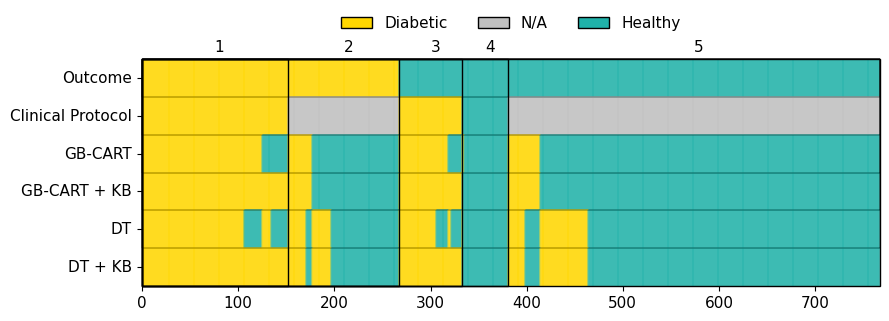

In [2130]:
res_df = res_df.sort_values(['Outcome','ClinicalProtocol','EQ','GB_CART_ML','DT_ML'], ascending=[False]*5)
res_df = res_df.reset_index(drop = True)

cmap = LinearSegmentedColormap.from_list('rg', [ "silver", "lightseagreen", "gold"], N=256) 

plt.rcParams['patch.edgecolor'] = 'none'
n = len(res_df.columns)-1

fig, axes = plt.subplots(figsize=(9, 3.4))

sns.heatmap(res_df.drop(columns = "EQ").T, cmap=cmap, cbar=False, alpha=0.4, xticklabels = 100, linewidths=0.1, ax=axes)
axes.set_yticklabels(['Outcome', 'Clinical Protocol', 'GB-CART', 'GB-CART + KB', 'DT', 'DT + KB'])
axes.tick_params(axis='both', which='major', labelsize=11)
colors = axes.collections[0].get_facecolors()
axes.collections[0].set_edgecolors(colors)

for r in range(1,len(res_df.columns)-1):
    axes.add_patch(Rectangle((0, 0),  len(res_df), r, fill=False, edgecolor="black", lw=0.3, clip_on=False))
axes.add_patch(Rectangle((0, 0), len(res_df), n, fill=False, edgecolor="black", lw=1, clip_on=False))

n1 = len(res_df[(res_df["Outcome"]==1) & (res_df["ClinicalProtocol"]==1)])
n2 = len(res_df[(res_df["Outcome"]==1)])
n3 = len(res_df[(res_df["Outcome"]==1)]) + len(res_df[(res_df["Outcome"]==0) & (res_df["ClinicalProtocol"]==1)])
n4 = len(res_df) - len(res_df[(res_df["Outcome"]==0) & (res_df["ClinicalProtocol"]==-1)])
n5 = len(res_df)

axes.add_patch(Rectangle((0, 0), n1, n, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n2, n, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n3, n, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n4, n, fill=False, edgecolor="black", lw=1, clip_on=False))

plt.text(n1/2,     -0.2, "1", size=11)
plt.text((n1+n2)/2,-0.2, "2", size=11)
plt.text((n2+n3)/2,-0.2, "3", size=11)
plt.text((n3+n4)/2,-0.2, "4", size=11)
plt.text((n4+n5)/2,-0.2, "5", size=11)

legend_elements = [
    Patch(facecolor="gold", edgecolor="black", label="Diabetic"),
    Patch(facecolor="silver", edgecolor="black", label="N/A"),
    Patch(facecolor="lightseagreen", edgecolor="black", label="Healthy")
]

legend = axes.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, fontsize=11)
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')
plt.subplots_adjust(hspace=0.2)
plt.tight_layout()
plt.show()
#plt.savefig("kbml_models.pdf")

## Results 3 - KB integration with agents requirements

In [2131]:
# import dataset
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
dataset["Outcome"].replace({0: 'healthy', 1: 'diabetes'}, inplace=True)

# split data
train, test = train_test_split(dataset, test_size=0.5, random_state=42, stratify=dataset["Outcome"])

X_train, y_train, X_test, y_test = train.iloc[:, :-1], train.iloc[:, -1], test.iloc[:, :-1], test.iloc[:, -1]
X_train, y_train = sampling(experiment, X_train, y_train)

predictor = train_and_evaluate('GradientBoosting', X_train, y_train, X_test, y_test)

GradientBoosting A = 0.75



In [2132]:
depth = 8
cart = Extractor.cart(predictor, max_depth=depth, max_leaves=depth, simplify=False)
theory_from_cart = cart.extract(train)
scores, completeness = get_scores(cart, test, predictor)
print(f'CART performance ({cart.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print()
print(pretty_theory(theory_from_cart))

CART performance (8 rules with 100.00% coverage):
Classification accuracy = 0.72 (data), 0.89 (BB)
F1 = 0.71 (data), 0.89 (BB)

'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes) :-
    Glucose > 143.5, DiabetesPedigreeFunction > 0.32.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose > 143.5, DiabetesPedigreeFunction =< 0.32, BMI =< 31.40.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes) :-
    Glucose > 143.5, DiabetesPedigreeFunction =< 0.32, BMI > 31.40.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose =< 143.5, Pregnancies =< 7.5, BMI =< 45.44.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes) :-
    Glucose =< 143.5, Pregn

In [2167]:
kb_rules = get_kb_rules()
ml_rules = parse_rules(pretty_theory(theory_from_cart))
all_rules = kb_rules + ml_rules

In [2168]:
test["Pred"] = np.nan
test["Rule"] = np.nan

In [2169]:
for index, row in test.iterrows():
    ruleid, outcome = get_rule(ml_rules, row)
    test.loc[index,"Rule"] = ruleid
    test.loc[index,"Pred"] = outcome

In [2170]:
# for index, row in dataset.iterrows():
#     ruleid, outcome = get_rule(all_rules, row)
#     test.loc[index,"Rule"] = ruleid
#     test.loc[index,"Pred"] = outcome

In [2171]:
test['Outcome_binary'] = test['Outcome'].map({'healthy': 0, 'diabetes': 1})
test['Pred_binary'] = test['Pred'].map({'healthy': 0, 'diabetes': 1})
test['Correct'] = (test['Outcome_binary'] == test['Pred_binary']).astype(int)

test['TP'] = ((test['Outcome_binary'] == 1) & (test['Pred_binary'] == 1)).astype(int)
test['TN'] = ((test['Outcome_binary'] == 0) & (test['Pred_binary'] == 0)).astype(int)
test['FN'] = ((test['Outcome_binary'] == 1) & (test['Pred_binary'] == 0)).astype(int)
test['FP'] = ((test['Outcome_binary'] == 0) & (test['Pred_binary'] == 1)).astype(int)

grouped = test.groupby('Rule').agg(
    total_predictions=('Correct', 'count'),
    correct_predictions=('Correct', 'sum'),
    total_positives=('Outcome_binary', 'sum'),
    true_positives=('TP', 'sum'),
    true_negatives=('TN', 'sum'),
    false_negatives=('FN', 'sum'),
    false_positives=('FP', 'sum'))

In [2173]:
grouped = grouped.reindex(range(depth))
grouped["outcome"] = [rule["outcome"] for rule in ml_rules]
grouped["n_conditions"] = [len(rule["conditions"]) for rule in ml_rules]
grouped['accuracy'] = round(grouped['correct_predictions'] / grouped['total_predictions'],3)
grouped['coverage'] = round(grouped['total_predictions'] / len(test),3)
grouped

,total_predictions,correct_predictions,total_positives,true_positives,true_negatives,false_negatives,false_positives,outcome,n_conditions,accuracy,coverage
Rule,,,,,,,,,,,
0,53,39,39.0,39,0,0,14,diabetes,2,0.736,0.069
1,14,5,9.0,0,5,9,0,healthy,3,0.357,0.018
2,18,12,12.0,12,0,0,6,diabetes,3,0.667,0.023
3,244,191,53.0,0,191,53,0,healthy,3,0.783,0.318
4,7,4,4.0,4,0,0,3,diabetes,3,0.571,0.009
5,16,7,7.0,7,0,0,9,diabetes,3,0.438,0.021
6,30,20,10.0,0,20,10,0,healthy,4,0.667,0.039
7,386,0,0.0,0,0,0,2,diabetes,4,0.000,0.503


In [2174]:
# initialise dataset
res_df = pd.DataFrame()
res_df["Outcome"] = dataset_rules["Outcome"]
res_df["ClinicalProtocol"] = dataset_rules["Rules"]
res_df["EQ"] = res_df["Outcome"]==res_df["ClinicalProtocol"]
res_df = res_df.fillna(-1)

In [2175]:
selected_rules = grouped[grouped["false_negatives"]==0].index.astype(int)
print(list(selected_rules))
ml_rules_selected = [ml_rules[i] for i in selected_rules]
res_df["CP update #1"] = dataset.apply(lambda row: get_outcome(row, kb_rules + ml_rules_selected), axis=1)

[0, 2, 4, 5, 7]


In [2176]:
selected_rules = grouped[grouped["accuracy"]>0.5].index.astype(int)
print(list(selected_rules))
ml_rules_selected = [ml_rules[i] for i in selected_rules]
res_df["CP update #2"] = dataset.apply(lambda row: get_outcome(row, kb_rules + ml_rules_selected), axis=1)

[0, 2, 3, 4, 6]


In [2177]:
selected_rules = grouped[grouped["coverage"]>0.05].index.astype(int)
print(list(selected_rules))
ml_rules_selected = [ml_rules[i] for i in selected_rules]
res_df["CP update #3"] = dataset.apply(lambda row: get_outcome(row, kb_rules + ml_rules_selected), axis=1)

[0, 3, 7]


In [2178]:
selected_rules = grouped[grouped["n_conditions"]<=3].index.astype(int)
print(list(selected_rules))
ml_rules_selected = [ml_rules[i] for i in selected_rules]
res_df["CP update #4"] = dataset.apply(lambda row: get_outcome(row, kb_rules + ml_rules_selected), axis=1)

[0, 1, 2, 3, 4, 5]


In [2179]:
res_df.replace({'diabetes': 1, 'healthy': 0, np.nan: -1}, inplace = True)
res_df["ML rules"] = [get_rule(ml_rules, row)[0]+2 for _, row in dataset.iterrows()]

In [ ]:
# order and rename
res_df = res_df.sort_values(['Outcome','ClinicalProtocol','EQ', 'ML rules', 'CP update #1','CP update #2','CP update #3','CP update #4'], 
                            ascending=[False]*8)
res_df = res_df.reset_index(drop = True)

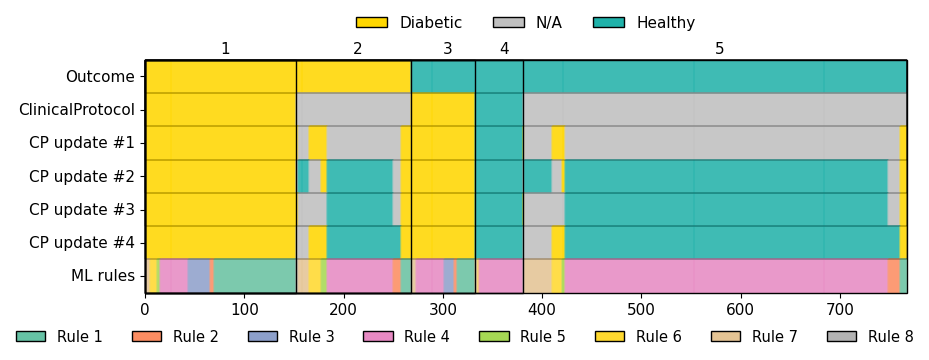

In [2182]:
plt.rcParams['patch.edgecolor'] = 'none'
n = len(res_df.columns)-1

fig, axes = plt.subplots(figsize=(9, 3.8))

cmap = LinearSegmentedColormap.from_list('rg', [ "silver", "lightseagreen", "gold"] + list(sns.color_palette("Set2", depth)), N=256) 
sns.heatmap(res_df.drop(columns = "EQ").T, cmap=cmap, cbar=False, alpha=0.4, xticklabels = 100, linewidths=0.1, ax=axes)
#axes.set_yticklabels(['Outcome', 'Clinical Protocol', 'GB-CART', 'GB-CART + KB', 'DT', 'DT + KB'])
axes.tick_params(axis='both', which='major', labelsize=11)
colors = axes.collections[0].get_facecolors()
axes.collections[0].set_edgecolors(colors)

for r in range(1,len(res_df.columns)-1):
    axes.add_patch(Rectangle((0, 0),  len(res_df), r, fill=False, edgecolor="black", lw=0.3, clip_on=False))
axes.add_patch(Rectangle((0, 0), len(res_df), n, fill=False, edgecolor="black", lw=1, clip_on=False))

n1 = len(res_df[(res_df["Outcome"]==1) & (res_df["ClinicalProtocol"]==1)])
n2 = len(res_df[(res_df["Outcome"]==1)])
n3 = len(res_df[(res_df["Outcome"]==1)]) + len(res_df[(res_df["Outcome"]==0) & (res_df["ClinicalProtocol"]==1)])
n4 = len(res_df) - len(res_df[(res_df["Outcome"]==0) & (res_df["ClinicalProtocol"]==-1)])
n5 = len(res_df)

axes.add_patch(Rectangle((0, 0), n1, n, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n2, n, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n3, n, fill=False, edgecolor="black", lw=1, clip_on=False))
axes.add_patch(Rectangle((0, 0), n4, n, fill=False, edgecolor="black", lw=1, clip_on=False))

plt.text(n1/2,     -0.2, "1", size=11)
plt.text((n1+n2)/2,-0.2, "2", size=11)
plt.text((n2+n3)/2,-0.2, "3", size=11)
plt.text((n3+n4)/2,-0.2, "4", size=11)
plt.text((n4+n5)/2,-0.2, "5", size=11)

rule_legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=f"Rule {i+1}")
    for i, color in enumerate(sns.color_palette("Set2", depth))
]

rule_legend = axes.legend(handles=rule_legend_elements, loc="upper center", bbox_to_anchor=(0.42, -0.10), ncol=8, fontsize=10.5)
rule_legend.get_frame().set_linewidth(0.0)
rule_legend.get_frame().set_facecolor('none')
rule_legend.get_frame().set_edgecolor('none')

# Add the second legend to the plot
axes.add_artist(rule_legend)

legend_elements = [
    Patch(facecolor="gold", edgecolor="black", label="Diabetic"),
    Patch(facecolor="silver", edgecolor="black", label="N/A"),
    Patch(facecolor="lightseagreen", edgecolor="black", label="Healthy")
]

legend = axes.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, fontsize=11)
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')

plt.tight_layout(pad = 0.4)
fig.subplots_adjust(bottom=0.2)
plt.show()
#plt.savefig("updated_models.pdf", bbox_extra_artists = rule_legend)

## Refit on entire dataset for deployment

In [1569]:
def convert_to_prolog_predicates(rules):
    prolog_predicates = []

    for rule in rules:
        conditions = rule['conditions']
        outcome = rule['outcome']
        vars_in_rule = list(set([cond['variable'] for cond in conditions]))

        if outcome == "healthy":
            action = "low_diabetes_risk"
        else:
            action = "alert_diabetes_risk"
            
        predicate = f"next_action({action}) :-\n"
        conditions_predicates = []

        for var in vars_in_rule:
            condition_predicate = f"\tcurrent_{var.lower()}({var})"
            conditions_predicates.append(condition_predicate)
        for condition in conditions:
            variable = condition['variable']
            operation = condition['operation']
            threshold = condition['threshold']

            condition_predicate = f"\t{variable} {operation} {threshold}"
            conditions_predicates.append(condition_predicate)

        predicate += ",\n".join(conditions_predicates) + "."
        prolog_predicates.append(predicate)

    return prolog_predicates

In [1451]:
# import dataset
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
dataset["Outcome"].replace({0: 'healthy', 1: 'diabetes'}, inplace=True)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [1452]:
model_name = 'GradientBoosting'
predictor = GridSearchCV(models[model_name], param_grids[model_name], n_jobs=-1, cv=5).fit(X, y)
best_params = predictor.best_params_ 
predictor = GradientBoostingClassifier(random_state=123, **best_params).fit(X, y)

# get rules
depth = 10
cart = Extractor.cart(predictor, max_depth=depth, max_leaves=depth, simplify=False)
theory_from_cart = cart.extract(dataset)
print('\nCART extracted rules:\n\n' + pretty_theory(theory_from_cart))


CART extracted rules:

'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes) :-
    Glucose > 127.5, BMI > 29.95, Age > 24.5.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose =< 127.5, Age =< 30.5.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose =< 106.5, Age > 30.5.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose in [106.5, 127.5], Age > 30.5, BMI =< 27.84.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose in [127.5, 158.5], BMI =< 29.95.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes) :-
    Glucose > 158.5, BMI =< 29.95.
'Outcome

In [1572]:
prolog_predicates = convert_to_prolog_predicates(rules)
for predicate in prolog_predicates:
    print(predicate,"\n")

next_action(alert_diabetes_risk) :-
	current_glucose(Glucose),
	current_diabetespedigreefunction(DiabetesPedigreeFunction),
	Glucose > 143.5,
	DiabetesPedigreeFunction > 0.32. 

next_action(low_diabetes_risk) :-
	current_glucose(Glucose),
	current_bmi(BMI),
	current_diabetespedigreefunction(DiabetesPedigreeFunction),
	Glucose > 143.5,
	DiabetesPedigreeFunction =< 0.32,
	BMI =< 31.4. 

next_action(alert_diabetes_risk) :-
	current_glucose(Glucose),
	current_bmi(BMI),
	current_diabetespedigreefunction(DiabetesPedigreeFunction),
	Glucose > 143.5,
	DiabetesPedigreeFunction =< 0.32,
	BMI > 31.4. 

next_action(low_diabetes_risk) :-
	current_pregnancies(Pregnancies),
	current_glucose(Glucose),
	current_bmi(BMI),
	Glucose =< 143.5,
	Pregnancies =< 7.5,
	BMI =< 45.44. 

next_action(alert_diabetes_risk) :-
	current_pregnancies(Pregnancies),
	current_glucose(Glucose),
	current_bmi(BMI),
	Glucose =< 143.5,
	Pregnancies =< 7.5,
	BMI > 45.44. 

next_action(alert_diabetes_risk) :-
	current_pregnancies